In [ ]:
# default_exp plotting

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Plotting

Collection of plotting functions for results

In [ ]:
# export
from pytorch_inferno.inference import get_likelihood_width

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Union, List, Dict
import numpy as np

from torch import Tensor

from fastcore.all import is_listy

In [ ]:
# export
plt_style    = {'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}
plt_sz       = 8
plt_cat_pal  = 'tab10'
plt_tk_sz    = 16     
plt_lbl_sz   = 24
plt_title_sz = 26 
plt_leg_sz   = 16

## Prediction histograms

In [ ]:
# export
def plot_preds(df:pd.DataFrame, bin_edges:np.ndarray=np.linspace(0.,1.,11), pred_names:Union[List[str],str]='pred') -> None:
    r'''Plots predictions and background variations'''
    if not is_listy(pred_names): pred_names = [pred_names]
    with sns.axes_style(**plt_style), sns.color_palette(plt_cat_pal) as palette:
        plt.figure(figsize=(plt_sz*16/9, plt_sz))
        for t,n in ((1,'Signal'),(0,'Background')):
            cut = (df['gen_target'] == t)
            hist_kws = {} if 'gen_weight' not in df.columns else {'weights':wgt_scale*df.loc[cut, 'gen_weight']}
            if t == 0:
                for i,p in enumerate(pred_names):
                    d = df.loc[cut, p]
                    sns.distplot(d, bins=bin_edges, label=f'{n}_{p}' if i > 0 else n, norm_hist=True, kde=False,
                                 hist_kws={'fill':not i > 0, 'edgecolor':palette[i+1] if i > 0 else None,
                                           'linewidth':2 if i > 0 else 1, **hist_kws})
            else:
                sns.distplot(df.loc[cut, pred_names[0]], bins=bin_edges, label=f'{n}', hist_kws=hist_kws, norm_hist=True, kde=False)
        plt.legend(fontsize=plt_leg_sz)
        plt.xlabel("Class prediction", fontsize=plt_lbl_sz)
        plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=plt_lbl_sz)
        plt.xticks(fontsize=plt_tk_sz)
        plt.yticks(fontsize=plt_tk_sz)
        plt.show() 

In [ ]:
s,b = np.random.normal(1,0.5,1000),np.random.normal(0,0.5,1000)
s,b = s[(s<1)&(s>0)][:,None],b[(b<1)&(b>0)][:,None]
s,b = np.hstack((s,np.ones_like(s))),np.hstack((b,np.zeros_like(b)))
d = np.vstack((s,b))
df = pd.DataFrame({'pred':d[:,0],'gen_target':d[:,1]})

In [ ]:
df.head()

,pred,gen_target
0,0.801512,1.0
1,0.724676,1.0
2,0.609403,1.0
3,0.713899,1.0
4,0.865791,1.0


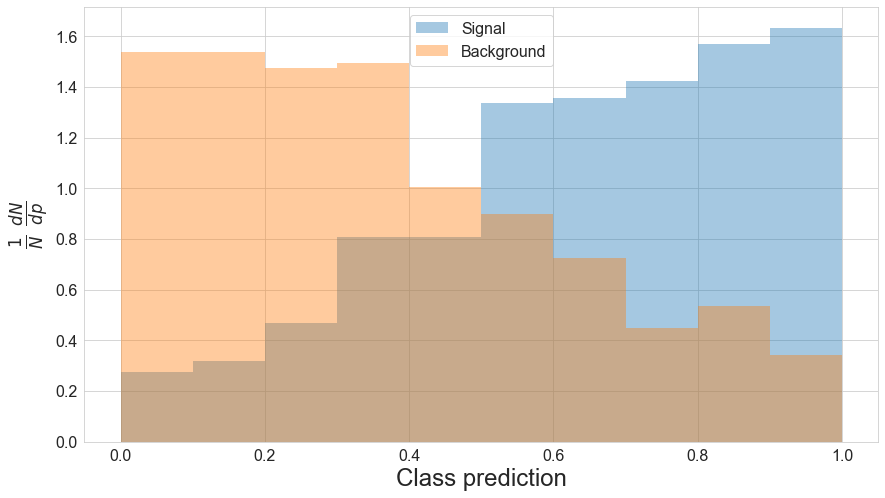

In [ ]:
plot_preds(df)

## Inference plots

In [ ]:
# export
def plot_likelihood(nlls:Union[Dict[str,Tensor],List[Tensor]], mu_scan:Tensor, labels:Optional[List[str]]=None) -> List[float]:
    if isinstance(nlls, dict):
        labels = list(nlls.keys())
        nlls = [nlls[k] for k in nlls]
    if not is_listy(nlls): nlls = [nlls]
    if labels is None: labels = ['' for _ in nlls]
    elif not is_listy(labels): labels = [labels]
    
    widths = []
    with sns.axes_style(**plt_style), sns.color_palette(plt_cat_pal) as palette:
        plt.figure(figsize=(plt_sz*16/9, plt_sz))
        plt.plot(mu_scan,0.5*np.ones_like(mu_scan), linestyle='--', color='black')
        for nll,lbl in zip(nlls,labels):
            dnll = nll-nll.min()  # Shift nll to zero
            try:               widths.append(get_likelihood_width(nll, mu_scan=mu_scan))
            except ValueError: widths.append(np.NaN)
            m = mu_scan[np.argmin(nll)]
            plt.plot(mu_scan, dnll, label=fr'{lbl} $\mu={mu_scan[np.argmin(nll)]}\pm{widths[-1]:.2f}$')
        plt.legend(fontsize=plt_leg_sz)
        plt.xlabel(r"$\mu$", fontsize=plt_lbl_sz)
        plt.ylabel(r"Profiled $\Delta\left(-L\right)$", fontsize=plt_lbl_sz)
        plt.xticks(fontsize=plt_tk_sz)
        plt.yticks(fontsize=plt_tk_sz)
        plt.show()

        return widths